# Applied Big Data Analytics in Finance

*By Daniel Deutsch, José Lucas Barretto, Karim Jaber and Ziyad Bekkaoui*

In [1]:
import glob
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 7),
    'axes.prop_cycle': plt.cycler(color=['#4C72B0', '#C44E52', '#55A868', '#8172B2', '#CCB974', '#64B5CD']),
    'axes.facecolor': '#EAEAF2'
})

# Data Import

At this stage, the only goal is to be able to import all the datasets into our code in the form of pandas dataframes.

## OHLCV

For each file provided by the professor, concatenates the given values into one single dataframe.

In [3]:
if os.path.exists("./datasets/ohlcv.csv.gz"):
    df_ohlcv = pd.read_csv("./datasets/ohlcv.csv.gz", index_col=0, )
else:
    df_ohlcv = pd.DataFrame()
    for filename in glob.glob("./datasets/ohlcv/*.xlsx"):
        try:
            df_tmp = pd.read_excel(
                filename, 
                usecols=[4, 6, 9, 10], 
                names=['', '', '', '', 'date', '', 'price', '', '', 'market_cap', 'volume'],
            )
            df_tmp['slug'] = filename
            df_ohlcv = pd.concat([df_ohlcv, df_tmp], ignore_index=True)
        except Exception:
            pass
    df_ohlcv.to_csv("./datasets/ohlcv.csv.gz")

## Crypto currencies Map

Obtains information over the cryptocurrencies map of each coin through the Coin Market Cap API.

In [4]:
# Makes the http request
url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/map"
headers = {
    'Accepts': "application/json", 
    'X-CMC_PRO_API_KEY': "1a073c3f-c968-40d8-9dcf-0340a3bd5796"
}
r = requests.get(url, headers=headers)
r = r.json()

# Creates a dataframe out of the response
df_cryptomap = pd.DataFrame(r['data'])

## Sentiment

Loads the sentiment dataset provided by the professor.

In [5]:
df_sentiment = pd.read_csv("./datasets/sentiment.csv.gz", index_col=0)

## Risk-Free Rate

As the provided article uses the one-month Treasury bill rate as the risk-free rate, we import from FRED the [Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity](https://fred.stlouisfed.org/series/DGS1MO).

In [6]:
df_rfr = pd.read_csv("./datasets/risk_free_rate.csv.gz")

# Data Processing

Here, the idea is to process the imported data into a format that is easier for us to interpret and manipulate it.

## OHLCV

In [7]:
# Changes columns dtypes
df_ohlcv['date'] = pd.to_datetime(df_ohlcv['date'])

# Keeps only first sample of duplicated rows
df_ohlcv.drop_duplicates(subset=['slug', 'date'], keep='first', inplace=True)

## Cryptocurrencies Map

In [8]:
# Keeps only useful columns
df_cryptomap = df_cryptomap[['symbol', 'slug', 'first_historical_data']]

# Transforms first_historical_data column dtype
df_cryptomap['first_historical_data'] = pd.to_datetime(df_cryptomap['first_historical_data']).dt.date.astype('datetime64')

## Sentiment

In [9]:
# Drop incomplete rows
df_sentiment.dropna(inplace=True)

# Represents bearish sentiment with -1 (instead of 0) 
df_sentiment['sentiment'] = df_sentiment['sentiment'].replace(0, -1)

# Renames the ticker to match CoinMarketCap symbol names
df_sentiment['ticker'] = df_sentiment['ticker'].apply(lambda ticker: ticker[:-2])
df_sentiment.rename(columns={'ticker': 'symbol'}, inplace=True)

# Obtains the average sentiment of each coin per day
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment = df_sentiment.set_index('date').groupby('symbol').resample('1d').mean().reset_index()

## Risk-Free Rate

In [10]:
# Renames the columns
df_rfr.rename(columns={'DATE': 'date', 'DGS1MO': 'rfr'}, inplace=True)

# Transforms date column dtype
df_rfr['date'] = pd.to_datetime(df_rfr['date'])

# Replaces '.' with 0 
df_rfr['rfr'] = df_rfr['rfr'].replace('.', '0')

## Dataframes Merge

In [18]:
# Merges ohlcv and cryptomap dataframes
df = pd.merge(df_ohlcv, df_cryptomap, on=['slug'], how='inner')

# Merges the previously merged dataframe with the sentiment one
df = pd.merge(df_sentiment, df, on=['date', 'symbol'], how='inner')

# Merges the previously merged dataframe with the risk-free rate one
df = pd.merge(df_rfr, df, on=['date'], how='inner')

# As some of the coins change their names/slugs over time but keep their symbol,
# there will be duplicated rows in the dataset.
# Keeps only first sample of duplicated rows (the most recent one)
df.drop_duplicates(subset=['symbol', 'date'], keep='first', inplace=True)

# Keeps only useful columns
df = df[['date', 'symbol', 'price', 'volume', 'market_cap', 'sentiment', 'first_historical_data', 'rfr']]

<AxesSubplot:>

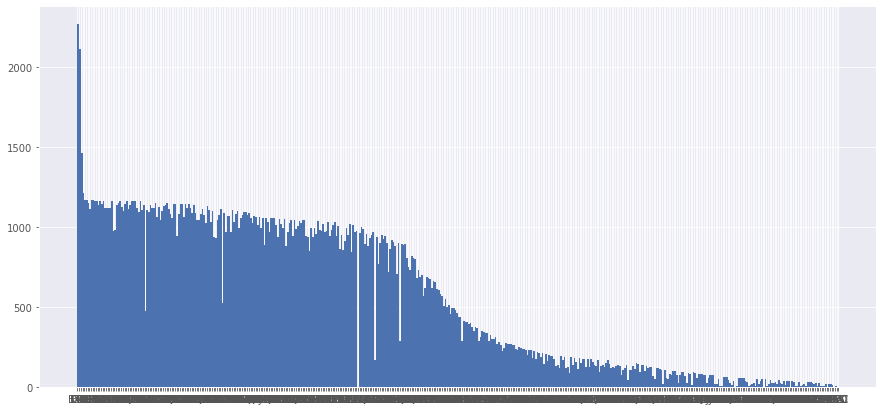

In [38]:
df['symbol'].hist(bins=len(df['symbol'].unique()))  ## MUST REMOVE COINS THAT HAVE FEWER OBSERVATIONS THAN A THRESHOLD

In [11]:
# Merges ohlcv and cryptomap dataframes
df = pd.merge(df_ohlcv, df_cryptomap, on=['slug'], how='inner')

# Merges the previously merged dataframe with the sentiment one
df = pd.merge(df_sentiment, df, on=['date', 'symbol'], how='inner')

# Merges the previously merged dataframe with the risk-free rate one
df = pd.merge(df_rfr, df, on=['date'], how='inner')

# As some of the coins change their names/slugs over time but keep their symbol,
# there will be duplicated rows in the dataset.
# Keeps only first sample of duplicated rows (the most recent one)
df.drop_duplicates(subset=['symbol', 'date'], keep='first', inplace=True)

# Keeps only useful columns
df = df[['date', 'symbol', 'price', 'volume', 'market_cap', 'sentiment', 'first_historical_data', 'rfr']]

# Transforms the dataframe into a multi-level column dataframe
df = df.set_index(['symbol', 'date']).stack().unstack('date').T
# df = df.set_index(['symbol', 'date']).unstack('symbol').swaplevel(0, 1, axis=1).sort_index(level=0, axis=1)

# Changes columns dtypes
df = df.apply(pd.to_numeric, errors='ignore')
df.loc(axis=1)[:, 'first_historical_data'] = df.loc(axis=1)[:, 'first_historical_data'].apply(pd.to_datetime)

# Fill the dataframe with missing dates
df = df.asfreq('D')

# Sorts the rows in ascending order of dates
df.sort_index(inplace=True)

# Deletes previous dataframes from memory
# del df_ohlcv
# del df_cryptomap
# del df_sentiment
# del df_rfr

# Data Enhancing

Once the data is in the right shape/format, we are able to obtain more useful information for our analysis through its manipulation.

In [12]:
# Obtains a list with the considered symbols and factors
symbols = df.columns.levels[0]
factors = [
    'mcap', 'prc', 'maxdprc', 'age',
    'r1', 'r2', 'r3', 'r4', 'r8', 'r16', 'r50', 'r100',
    'vol', 'prcvol', 'volscaled',
    'beta', 'beta2', 'idiovol', 'retvol', 'retskew', 'retkurt', 'maxret', 'delay', 'stdprcvol', 'damihud',
    'sentiment'
]

for i, s in enumerate(symbols):

    print(f"\rsymbol={s}, {i+1}/{len(symbols)}", end="")

    # Adds temporary useful columns
    df[(s, 'portfolio_formation_week')] = ( df.index - df.index.min() ) // np.timedelta64(1, 'W')
    df[(s, 'r')] = df[(s, 'price')].pct_change()
    df[(s, 'cmkt')] = df[(s, 'r')] - df[(s, 'rfr')]
    df[(s, 'r/volume')] = df[(s, 'r')] / df[(s, 'volume')]

    # Rolling OLS model Ri − Rf = αi + βi CMKT + ϵi.
    model = RollingOLS(endog=df[(s, 'price')].pct_change(), exog=sm.add_constant(df[(s, 'cmkt')]), window=365)
    beta = model.fit(params_only=True)._params[:, 1]

    # Size factors
    df[(s, 'mcap')] = np.log( df[(s, 'market_cap')].shift(1) )
    df[(s, 'prc')] = np.log( df[(s, 'price')].shift(1) )
    df[(s, 'maxdprc')] = df[s].groupby('portfolio_formation_week')['price'].transform('max')
    df[(s, 'age')] = ( df.index - df[(s, 'first_historical_data')] ) // np.timedelta64(1, 'W')

    # Momentum factors
    df[(s, 'r1')] = df[(s, 'price')].pct_change(7)
    df[(s, 'r2')] = df[(s, 'price')].pct_change(7*2)
    df[(s, 'r3')] = df[(s, 'price')].pct_change(7*3)
    df[(s, 'r4')] = df[(s, 'price')].pct_change(7*4)
    df[(s, 'r8')] = df[(s, 'price')].pct_change(7*8)
    df[(s, 'r16')] = df[(s, 'price')].pct_change(7*16)
    df[(s, 'r50')] = df[(s, 'price')].pct_change(7*50)
    df[(s, 'r100')] = df[(s, 'price')].pct_change(7*100)

    # Volume factors
    df[(s, 'vol')] = np.log( df[(s, 'volume')] )
    df[(s, 'prcvol')] = np.log( df[(s, 'price')] * df[(s, 'volume')] )
    df[(s, 'volscaled')] = np.log( df[(s, 'price')] * df[(s, 'volume')] / df[(s, 'market_cap')] )

    # Volatility factors
    df[(s, 'beta')] = beta
    df[(s, 'beta2')] = beta**2
    # df[(s, 'idiovol')] = 
    df[(s, 'retvol')] = df[s].groupby('portfolio_formation_week')['r'].transform('std')
    df[(s, 'retskew')] = df[s].groupby('portfolio_formation_week')['r'].transform('skew')
    df[(s, 'retkurt')] = df[s].groupby('portfolio_formation_week')['r'].transform(pd.DataFrame.kurtosis)
    df[(s, 'maxret')] = df[s].groupby('portfolio_formation_week')['r'].transform('max')
    # df[(s, 'delay')] = 
    df[(s, 'stdprcvol')] = np.log(df[s].groupby('portfolio_formation_week')['volume'].transform('std'))
    df[(s, 'damihud')] = df[s].groupby('portfolio_formation_week')['r/volume'].transform('mean')

    # Extra factors
    df[(s, 'sentiment')] = df[(s, 'sentiment')]

    # Removes unused columns
    # df.drop((s, 'price'), axis=1, inplace=True)
    # df.drop((s, 'volume'), axis=1, inplace=True)
    # df.drop((s, 'market_cap'), axis=1, inplace=True)
    # df.drop((s, 'first_historical_data'), axis=1, inplace=True)
    # df.drop((s, 'portfolio_formation_week'), axis=1, inplace=True)
    # df.drop((s, 'r'), axis=1, inplace=True)
    # df.drop((s, 'cmkt'), axis=1, inplace=True)
    # df.drop((s, 'r/volume'), axis=1, inplace=True)

symbol=1INCH, 1/454
symbol=2CRZ, 2/454
symbol=AAVE, 3/454
symbol=ACT, 4/454
symbol=ADA, 5/454
symbol=AE, 6/454
symbol=AEON, 7/454
symbol=AION, 8/454
symbol=ALBT, 9/454
symbol=ALCX, 10/454
symbol=ALGO, 11/454
symbol=ALICE, 12/454
symbol=AMB, 13/454
symbol=AMP, 14/454
symbol=ANKR, 15/454
symbol=ANT, 16/454
symbol=API3, 17/454
symbol=APPC, 18/454
symbol=AR, 19/454
symbol=ARDR, 20/454
symbol=ARK, 21/454
symbol=ARMOR, 22/454


ValueError: zero-size array to reduction operation maximum which has no identity

# Analysis

Now that we have all the information that we need and in the format that we want, we are able to start our analysis.

## Filtering

In this project we intend to only consider coins with market capitalization above $1,000,000 on the last date.

In [ ]:
for s in symbols:

    # Removes coins with market capitalization below 1M dollars
    if df[(s, 'mcap')].iloc[-1] < np.log(1E6):
        df.drop(s, axis=1, level=0, inplace=True)


NFT, 3533353.93
NYC, 5438668.01
PI, 7572394.59
RUNE, 2352193.53
TRTL, 3699982.88
VIBE, 7549277.73


symbol         1INCH                                        2CRZ         \
               price        volume    market_cap sentiment price volume   
date                                                                      
2013-04-28       NaN           NaN           NaN       NaN   NaN    NaN   
2013-04-29       NaN           NaN           NaN       NaN   NaN    NaN   
2013-04-30       NaN           NaN           NaN       NaN   NaN    NaN   
2013-05-01       NaN           NaN           NaN       NaN   NaN    NaN   
2013-05-02       NaN           NaN           NaN       NaN   NaN    NaN   
...              ...           ...           ...       ...   ...    ...   
2021-12-28  2.544229  1.530006e+08  1.073909e+09       NaN   NaN    NaN   
2021-12-29  2.414601  1.145194e+08  1.020271e+09       1.0   NaN    NaN   
2021-12-30  2.466028  1.185833e+08  1.042177e+09       NaN   NaN    NaN   
2021-12-31  2.394650  9.085467e+07  1.012018e+09       NaN   NaN    NaN   
2022-01-01  2.530239  6.876758e+07  1.069328e+09       NaN   NaN    NaN   

symbol                                 AAVE                ...        ZOO  \
           market_cap sentiment       price        volume  ... market_cap   
date                                                       ...              
2013-04-28        NaN       NaN         NaN           NaN  ...        NaN   
2013-04-29        NaN       NaN         NaN           NaN  ...        NaN   
2013-04-30        NaN       NaN         NaN           NaN  ...        NaN   
2013-05-01        NaN       NaN         NaN           NaN  ...        NaN   
2013-05-02        NaN       NaN         NaN           NaN  ...        NaN   
...               ...       ...         ...           ...  ...        ...   
2021-12-28        NaN       NaN  252.561107  9.148273e+08  ...        NaN   
2021-12-29        NaN       NaN  235.536969  5.064544e+08  ...        NaN   
2021-12-30        NaN       NaN  263.406785  4.660521e+08  ...        NaN   
2021-12-31        NaN       NaN  255.110495  4.974118e+08  ...        NaN   
2022-01-01        NaN       NaN  265.499839  3.068584e+08  ...        NaN   

symbol                ZORA                                   ZRX               \
           sentiment price volume market_cap sentiment     price       volume   
date                                                                            
2013-04-28       NaN   NaN    NaN        NaN       NaN       NaN          NaN   
2013-04-29       NaN   NaN    NaN        NaN       NaN       NaN          NaN   
2013-04-30       NaN   NaN    NaN        NaN       NaN       NaN          NaN   
2013-05-01       NaN   NaN    NaN        NaN       NaN       NaN          NaN   
2013-05-02       NaN   NaN    NaN        NaN       NaN       NaN          NaN   
...              ...   ...    ...        ...       ...       ...          ...   
2021-12-28       NaN   NaN    NaN        NaN       NaN  0.801350  43846140.14   
2021-12-29       NaN   NaN    NaN        NaN       NaN  0.760132  50153386.08   
2021-12-30       NaN   NaN    NaN        NaN       NaN  0.797074  40764341.56   
2021-12-31       NaN   NaN    NaN        NaN       NaN  0.804408  48661284.24   
2022-01-01       NaN   NaN    NaN        NaN       NaN  0.866343  50251104.31   

symbol                              
              market_cap sentiment  
date                                
2013-04-28           NaN       NaN  
2013-04-29           NaN       NaN  
2013-04-30           NaN       NaN  
2013-05-01           NaN       NaN  
2013-05-02           NaN       NaN  
...                  ...       ...  
2021-12-28  6.791410e+08       NaN  
2021-12-29  6.442090e+08       NaN  
2021-12-30  6.755173e+08       NaN  
2021-12-31  6.817322e+08       1.0  
2022-01-01  7.342220e+08       NaN  

[3171 rows x 1812 columns]

## Portfolio Selection

In [ ]:
df = pd.read_csv("./datasets/full.csv.gz", index_col=0, parse_dates=[0])
returns = df.groupby(['ticker', 'date'])[['close']].sum().stack().unstack(level=0).reset_index(level=1, drop=True)
returns = np.log(returns) - np.log(returns).shift()

c:\Users\Dell\Desktop\Code\FTD\Big Data in Finance\project\venv\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [ ]:
factor = df.groupby(['ticker', 'date'])[['market_cap']].sum().stack().unstack(level=0).reset_index(level=1, drop=True)
factor = np.log(factor).shift(1)
short_mask = factor.quantile(0.1, axis=1)
long_mask = factor.quantile(0.9, axis=1)
strat = -1*factor.lt(short_mask, axis=0) + 1*factor.gt(long_mask, axis=0)

c:\Users\Dell\Desktop\Code\FTD\Big Data in Finance\project\venv\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\Dell\Desktop\Code\FTD\Big Data in Finance\project\venv\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\Dell\Desktop\Code\FTD\Big Data in Finance\project\venv\lib\site-packages\numpy\lib\function_base.py:4488: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
c:\Users\Dell\Desktop\Code\FTD\Big Data in Finance\project\venv\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\Dell\Desktop\Code\FTD\Big Data in Finance\project\venv\lib\site-packages\numpy\lib\function_base.py:4488: RuntimeWarning: invalid value encountered in

In [ ]:
strat_returns = (strat*returns).mean(axis=1).dropna()

In [ ]:
returns

ticker,0xBTC,1ART,1INCH,1WO,2CRZ,8PAY,AAVE,ABT,ABYSS,ACE,...,ZOO,ZOON,ZORA,ZRX,ZUSD,ZYN,aEth,eRSDL,erowan,vSXP
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,0.212601,0.044928,-0.092231,-0.057223,-0.102878,-0.055931,-0.091442,-0.055052,-0.069836,-0.138457,...,-0.084190,-0.030902,-0.317435,-0.089680,0.006018,0.024422,-0.065989,-0.090579,-0.099131,-0.094172
2021-12-29,0.009132,0.003267,-0.052294,-0.035137,-0.028810,-0.000394,-0.069785,-0.013785,-0.090346,-0.073045,...,0.023470,-0.097930,0.517396,-0.052806,-0.000850,-0.000763,-0.041957,-0.005818,-0.010176,0.021054
2021-12-30,0.057112,0.091945,0.021075,0.019999,-0.012316,-0.067182,0.111832,0.012369,0.017480,-0.007194,...,0.061892,0.018508,-0.571277,0.047456,0.001724,-0.025223,0.019400,-0.052908,-0.023743,0.225422


In [ ]:
returns

ticker,0xBTC,1ART,1INCH,1WO,2CRZ,8PAY,AAVE,ABT,ABYSS,ACE,...,ZOO,ZOON,ZORA,ZRX,ZUSD,ZYN,aEth,eRSDL,erowan,vSXP
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,0.212601,0.044928,-0.092231,-0.057223,-0.102878,-0.055931,-0.091442,-0.055052,-0.069836,-0.138457,...,-0.084190,-0.030902,-0.317435,-0.089680,0.006018,0.024422,-0.065989,-0.090579,-0.099131,-0.094172
2021-12-29,0.009132,0.003267,-0.052294,-0.035137,-0.028810,-0.000394,-0.069785,-0.013785,-0.090346,-0.073045,...,0.023470,-0.097930,0.517396,-0.052806,-0.000850,-0.000763,-0.041957,-0.005818,-0.010176,0.021054
2021-12-30,0.057112,0.091945,0.021075,0.019999,-0.012316,-0.067182,0.111832,0.012369,0.017480,-0.007194,...,0.061892,0.018508,-0.571277,0.047456,0.001724,-0.025223,0.019400,-0.052908,-0.023743,0.225422


In [ ]:
(100*((1+strat_returns).cumprod())).tail(440)

date
2020-10-19    2.666713
2020-10-20    2.647179
2020-10-21    2.644796
2020-10-22    2.630359
2020-10-23         inf
                ...   
2021-12-28         inf
2021-12-29         inf
2021-12-30         inf
2021-12-31         inf
2022-01-01         inf
Length: 440, dtype: float64

In [ ]:
def ma_strat(long_term_window, short_term_window, returns):
    ma_long_term = prices.rolling(long_term_window).mean()
    ma_short_term = prices.rolling(short_term_window).mean()

    mask = ma_long_term.iloc[:,0].isna()
    ma_long_term = ma_long_term.loc[~mask]
    ma_short_term = ma_short_term.loc[~mask]
    returns = returns.loc[~mask]

    strat = 2*(ma_short_term > ma_long_term) - 1
    strat_returns = strat*(returns.shift(-1))
    
    return strat_returns, strat

In [ ]:
strat_returns, strat = ma_strat(50, 15, returns)

fig, ax = plt.subplots()
(1+strat_returns).cumprod().mean(axis=1).plot(ax=ax, label="strategy")
(1+returns).loc[strat_returns.index, :].cumprod().mean(axis=1).plot(ax=ax, label="market")
plt.grid(alpha=0.6)
plt.legend(loc="lower left")
plt.show()

In [ ]:
def volatility(strat_returns):
    cum_returns = strat_returns.dropna().mean(axis=1)
    annualized_vol = cum_returns.std()*np.sqrt(252)
    return annualized_vol

# RF RATE MISSING
def sharpe_ratio(strat_returns):
    cum_returns = strat_returns.dropna().mean(axis=1)
    sr = cum_returns.mean()/cum_returns.std()
    annualized_sr = sr*np.sqrt(252)
    return annualized_sr

def max_drawdown(strat_returns):
    cum_returns = strat_returns.dropna().mean(axis=1)
    max_dd = (cum_returns.iloc[-1] - cum_returns.max())/cum_returns.max()
    return max_dd


In [ ]:
sharpe_ratio(strat_returns)

In [ ]:
max_drawdown(strat_returns)

In [ ]:
tickers = ['BTC', 'ETH']
factors = ['price', 'sentiment']
columns = pd.MultiIndex.from_product([tickers, factors], names=['tickers', 'factors'])
df = pd.DataFrame(columns=columns)

In [ ]:
df['BTC', 'price']